# Draft of EKF implementation for temporal alignment

Using CTRA model.

Heavily based on [balzer82 implementation](https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb) and [giovannix adaptation](https://github.com/giovannix/kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb).

In [1]:
from sympy import symbols, Matrix, init_printing
from IPython.display import display

init_printing()

vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

hs = Matrix([[xs],
             [ys],
             [psis],
             [vs],
             [dpsis],
             [axs]])

state = Matrix([xs,ys,psis,vs,dpsis,axs])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]
x_noisy_measurement = []
y_noisy_measurement = []
x_predicted = []
y_predicted = []

In [2]:
def log_state_and_noises(iteration, state, predicted_state, noises, dt):
    updated_state_s, noise_s, sensors_std_s, = symbols('updated\_state noise sensors\_std')
    
    p_x, p_y, p_psi, p_v, p_dotpsi, p_a = symbols('\hat\ x \hat\ y \hat\ \psi \hat\ v \hat{\dot{\psi}} \hat\ a')
    predicted_state_matrix_s = Matrix([p_x, p_y, p_psi, p_v, p_dotpsi, p_a])
    predicted_state_s = symbols('predicted\_state')
    
    print(f'Iteration {iteration}, dt = {dt}:')
    print('='*100)
    
    print("Predicted state", list(predicted_state.T[0]))
    print("Updated state", x.reshape(-1).tolist()[0])

    display(Eq(
        predicted_state_s,
        Eq(
            predicted_state_matrix_s,
            Matrix(predicted_state),
            evaluate=False
        )
    ))
    
    print('-'*100)
    display(Eq(
        updated_state_s,
        Eq(state, Matrix(x), evaluate=False)
    ))
    
    print('*Noise included')  
    print('-'*100)
    
    display(Eq(
        Le(
            -sensors_std_s,
            Le(noise_s, sensors_std_s),
            evaluate=False
        ),
        Le(
            Matrix(-sensors_std),
            Le(Matrix(noises), Matrix(sensors_std), evaluate=False),
            evaluate=False
        )
    ))

    print('='*100)

In [3]:
import numpy as np
from numpy.random import default_rng
from sympy import Matrix, Eq, Le, Ge, symbols, init_printing
from copy import deepcopy
from IPython.display import display

init_printing()

STATE_SIZE = 6 # States
STATE_X_IDX, STATE_Y_IDX, STATE_YAW_IDX, STATE_VELOCITY_IDX, STATE_YAW_RATE_IDX, STATE_ACCELERATION_IDX = range(STATE_SIZE)

# Generated running the loop with correction commented, just with prediction
measurements_mock = np.array([
    [3.7538, 0.4616, 1.761, 6.6948, 0.4488, 4.0],
    [2.8449, 3.5203, 1.9512, 8.3896, 0.4488, 4.0],
    [1.0564, 6.6834, 2.2174, 8.8133, 0.6283, 1.0],
    [-1.627, 9.3919, 2.4836, 9.237, 0.6283, 1.0],
    [-5.0039, 11.3473, 2.7498, 9.237, 0.6283, 0.0],
    [-8.7762, 12.3455, 3.016, 9.237, 0.6283, 0.0],
    [-12.7749, 13.1978, 2.8496, 10.0844, -0.3927, 2.0],
    [-16.9109, 14.8321, 2.6832, 10.9318, -0.3927, 2.0],
    [-20.7895, 17.6414, 2.3504, 11.7792, -0.7854, 2.0],
    [-23.7432, 21.856, 2.0176, 12.6266, -0.7854, 2.0],
    [-26.3263, 27.2473, 2.0176, 15.5925, 0.0, 7.0],
    [-29.1809, 33.2053, 2.0176, 15.5925, 0.0, 0.0],
])

noises_mock = np.array([
    [0.7317, 0.8656, 0.0095, -0.5005, 0.0835, -0.4629],
    [-0.0571, -1.0837, -0.0015, 0.4288, -0.0634, -0.0808],
    [-0.5773, -1.1117, -0.0182, -0.778, 0.0696, -0.4022],
    [0.8567, 1.2855, 0.0112, -0.2399, 0.0904, -0.3941],
    [-0.8416, 0.1583, 0.0063, -0.6525, 0.084, -0.3697],
    [1.1896, -0.95, 0.0111, 0.4016, 0.0349, -0.1406],
    [0.5857, -0.9672, -0.0158, 0.3913, -0.0223, 0.2368],
    [-0.5729, -0.5062, 0.0078, -0.6339, -0.0688, 0.1991],
    [0.2298, 0.2873, -0.0159, 0.0898, -0.0375, -0.3652],
    [-0.2236, 0.5324, -0.0147, -0.1144, 0.0552, 0.3881],
    [0.6675, -0.5955, 0.018, 0.6145, -0.0493, -0.0704],
    [1.391, -1.0449, 0.0106, 0.9431, 0.0677, 0.3961],
])

def predict(x, P, dt):
    noise_pos     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_course  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
    noise_velocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_yawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
    noise_accel   = 0.5 # assume 0.5m/s2

    # TODO: Can be improved and calibratred
    Q = np.diag([noise_pos**2, noise_pos**2, noise_course**2, noise_velocity**2, noise_yawrate**2, noise_accel**2])
    
    pos_x, pos_y, yaw, velocity, yaw_rate, acceleration = x

    if np.abs(yaw_rate) < 0.00001: # Driving straight
        yaw_rate = 0.00001

    x[STATE_X_IDX] = pos_x + (1 / yaw_rate**2) * \
        ( \
            (velocity*yaw_rate + acceleration * yaw_rate * dt) * np.sin(yaw + yaw_rate* dt) \
            + acceleration * np.cos(yaw + yaw_rate * dt) \
            - velocity * yaw_rate * np.sin(yaw) - acceleration * np.cos(yaw) \
        )

    x[STATE_Y_IDX] = pos_y + (1 / yaw_rate**2) * \
        ( \
            (-velocity*yaw_rate - acceleration * yaw_rate * dt) * np.cos(yaw + yaw_rate* dt) \
            + acceleration * np.sin(yaw + yaw_rate * dt) \
            + velocity * yaw_rate * np.cos(yaw) - acceleration * np.sin(yaw) \
        )

    x[STATE_YAW_IDX] = (yaw + yaw_rate * dt + np.pi) % (2.0 * np.pi) - np.pi
    x[STATE_VELOCITY_IDX] = velocity + acceleration * dt 
    x[STATE_YAW_RATE_IDX] = yaw_rate
    x[STATE_ACCELERATION_IDX] = acceleration

    pos_x, pos_y, yaw, velocity, yaw_rate, acceleration = x

    # Calculate the Jacobian of the Dynamic Matrix A
    a13 = ( \
      (-yaw_rate*velocity*np.cos(yaw) + acceleration*np.sin(yaw) \
      - acceleration*np.sin(dt*yaw_rate + yaw) + (dt*yaw_rate*acceleration + yaw_rate*velocity)*np.cos(dt*yaw_rate \
      + yaw))/yaw_rate**2 \
    ).item(0)

    a14 = ( \
      (-yaw_rate*np.sin(yaw) + yaw_rate*np.sin(dt*yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)

    a15 = ( \
      ( \
        -dt*acceleration*np.sin(dt*yaw_rate + yaw) + dt*(dt*yaw_rate*acceleration + yaw_rate*velocity) \
        * np.cos(dt*yaw_rate + yaw) - velocity*np.sin(yaw) + (dt*acceleration + velocity) \
        * np.sin(dt*yaw_rate + yaw) \
      ) / yaw_rate**2 \
      - 2*( \
        -yaw_rate*velocity*np.sin(yaw) - acceleration \
        * np.cos(yaw) + acceleration*np.cos(dt*yaw_rate + yaw) + (dt*yaw_rate*acceleration + yaw_rate*velocity) \
        * np.sin(dt*yaw_rate + yaw) \
      ) / yaw_rate**3 \
    ).item(0)

    a16 = ( \
      (dt*yaw_rate*np.sin(dt*yaw_rate + yaw) - np.cos(yaw) + np.cos(dt * yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)

    a23 = ( \
      ( \
        -yaw_rate * velocity * np.sin(yaw) - acceleration * np.cos(yaw) + acceleration * np.cos(dt * yaw_rate + yaw) \
        - (-dt * yaw_rate*acceleration - yaw_rate * velocity) * np.sin(dt * yaw_rate + yaw) \
      ) / yaw_rate**2 \
    ).item(0)

    a24 = ( \
      (yaw_rate * np.cos(yaw) - yaw_rate*np.cos(dt*yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)

    a25 = ( \
      ( \
        dt * acceleration*np.cos(dt*yaw_rate + yaw) - dt * (-dt*yaw_rate*acceleration - yaw_rate * velocity) \
        * np.sin(dt * yaw_rate + yaw) + velocity*np.cos(yaw) + (-dt*acceleration - velocity)*np.cos(dt*yaw_rate + yaw) \
      ) / yaw_rate**2 \
      - 2*( \
        yaw_rate*velocity*np.cos(yaw) - acceleration * np.sin(yaw) + acceleration * np.sin(dt*yaw_rate + yaw) \
        + (-dt * yaw_rate * acceleration - yaw_rate * velocity)*np.cos(dt*yaw_rate + yaw) \
      ) / yaw_rate**3 \
    ).item(0)

    a26 = ( \
      (-dt*yaw_rate*np.cos(dt*yaw_rate + yaw) - np.sin(yaw) + np.sin(dt*yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)
      
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

    return x, P


def update(measurement, x, P, R):
    hx = x.copy()  # Not making any transformation and considering all the atributes are being measured

    # Identity because is assumed that for each attribute in state there exists a respective measurement attribute
    JH = np.eye(hx.shape[0])

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurement.reshape(JH.shape[0], 1)
    y = Z - hx  # Innovation or Residual
    x = x + K*y

    # Update the error covariance
    P = (np.eye(STATE_SIZE) - K*JH)*P
            
    # TODO: Remove in main C++ code
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

    return x, P

if __name__ == '__main__':
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
    
    std_pos = 1.5 # standard deviation of positioning measurements
    std_speed = 1.0 # standard deviation of the speed measurements
    std_yawrate = 0.1 # standard deviation of the yawrate measurements
    std_yaw = 0.02 # standard deviation of the yaw measurements
    std_acc = 0.5 # standard deviation of the longitudinal acceleration

    R = np.diag([std_pos**2, std_pos**2, std_yaw**2, std_speed**2, std_yawrate**2, std_acc**2])

    initial_state = np.array([[4, -2, np.pi/2, 5, np.pi/7, 4]], dtype='float64').T
    initial_noise = np.array([[-1.044, 1.0289, -0.0145, 0.9013, -0.0183, 0.0579]]).T
      
    x = initial_state + initial_noise
      
    random_generator = default_rng()
    
#     dts = [random_generator.random() for _ in measurements_mock]
#     dts = [np.round(dt, 4) for dt in dts]
#     print(dts)
    dts = (0.4571, 0.5364, 0.1067, 0.5539, 0.0843, 0.0452, 0.017, 0.1824, 0.5568, 0.9355, 0.2909, 0.1086, 0.4237)
    
    measurements = deepcopy(measurements_mock)
    
    all_noises, all_states, all_ps = [], [], []

    # for i, (measurement, dt) in enumerate(zip(measurements, dts), 1):
    for i, (measurement, noises, dt) in enumerate(zip(measurements, noises_mock, dts), 1):
        sensors_std = np.array([std_pos, std_pos, std_yaw, std_speed, std_yawrate, std_acc])
        
        # Adding noise
#         noises = (random_generator.random() for _ in sensors_std)
#         noises = np.array([n * 2*std - std for std, n in zip(sensors_std, noises)])  # Putting noises in std range
        measurement += noises
        all_noises.append(noises)
        
        x_noisy_measurement.append(measurement[STATE_X_IDX])
        y_noisy_measurement.append(measurement[STATE_Y_IDX])
         
        x, P = predict(x, P, dt)  # <==== EKF
        predicted_state = deepcopy(x)

        x, P = update(measurement, x, P, R)  # <===== EKF

        log_state_and_noises(i, state, predicted_state, noises, dt)
        all_states.append(x)
        all_ps.append(P)
        
        x_predicted.append(predicted_state[STATE_X_IDX])
        y_predicted.append(predicted_state[STATE_Y_IDX])
        

Iteration 1, dt = 0.4571:
Predicted state [2.6810304950959454, 2.133156663915952, 1.7530773970743105, 7.75616609, 0.4304989505128276, 4.0579]
Updated state [4.20009035106605, 1.4065263332970936, 1.7703242101697527, 6.231636758416404, 0.5331593429620153, 3.5436312687426756]


                  ⎡     \hat x     ⎤   ⎡2.68103049509595 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢2.13315666391595 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.75307739707431 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢   7.75616609    ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.430498950512828⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣     4.0579      ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡4.20009035106605 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢1.40652633329709 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.77032421016975 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢ 6.2316367584164 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.533159342962015⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣3.54363126874268 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.7317 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.8656 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0095 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.5005⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0835 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.4629⎦   ⎣0.5 ⎦

Iteration 2, dt = 0.5364:
Predicted state [matrix([[2.88776078, 5.0146889 , 2.05631088, 8.13244057, 0.53315934,
         3.54363127]])]
Updated state [2.8852973674160736, 3.458358682552544, 1.956315006275554, 8.78507759735717, 0.3874558538512966, 3.790217831441626]


                  ⎡     \hat x     ⎤   ⎡2.88776078354664 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢5.01468889656252 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.05631088173458 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢8.13244057096998 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.533159342962015⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣3.54363126874268 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡2.88529736741607 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢3.45835868255254 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.95631500627555 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.78507759735717 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.387455853851297⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣3.79021783144163 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.0571⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.0837⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0015⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.4288 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0634⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.0808⎦   ⎣0.5 ⎦

Iteration 3, dt = 0.1067:
Predicted state [matrix([[2.50629803, 4.33915433, 1.99765655, 9.18949384, 0.38745585,
         3.79021783]])]
Updated state [1.6803729482842633, 4.745379253143368, 2.1201655632219043, 8.4306370472555, 0.6643258142409749, 1.7948046228444299]


                  ⎡     \hat x     ⎤   ⎡2.50629803108141 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢4.33915433346289 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.99765654588149 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.18949383997199 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.387455853851297⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣3.79021783144163 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡1.68037294828426 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢4.74537925314337 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢ 2.1201655632219 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢ 8.4306370472555 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.664325814240975⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣1.79480462284443 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.5773⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.1117⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0182⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.778 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0696 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.4022⎦   ⎣0.5 ⎦

Iteration 4, dt = 0.5539:
Predicted state [matrix([[-1.62353688,  8.38727129,  2.48813563,  9.42477933,  0.66432581,
          1.79480462]])]
Updated state [-1.1473434810234227, 9.626337021148673, 2.4941321896864523, 9.008778587586454, 0.7170480449398828, 1.0589448581378393]


                  ⎡     \hat x     ⎤   ⎡-1.62353688087509⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢8.38727129181504 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.48813563172998 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.42477932784903 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.664325814240975⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣1.79480462284443 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-1.14734348102342⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢9.62633702114867 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.49413218968645 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢9.00877858758645 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.717048044939883⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣1.05894485813784 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.8567 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢1.2855 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0112 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.2399⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0904 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.3941⎦   ⎣0.5 ⎦

Iteration 5, dt = 0.0843:
Predicted state [matrix([[-1.76964785, 10.06796847,  2.55457934,  9.09804764,  0.71704804,
          1.05894486]])]
Updated state [-3.262337015138033, 10.51575544005283, 2.665352110328649, 8.818769860751926, 0.7839350612765527, 0.17681219842871987]


                  ⎡     \hat x     ⎤   ⎡-1.76964784890326⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢10.0679684728357 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.55457933987488 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.09804763912747 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.717048044939883⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣1.05894485813784 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-3.26233701513803⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢10.5157554400528 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.66535211032865 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.81876986075193 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.783935061276553⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣0.17681219842872 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.8416⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.1583 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0063 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.6525⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢ 0.084 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.3697⎦   ⎣0.5 ⎦

Iteration 6, dt = 0.0452:
Predicted state [matrix([[-3.61991567, 10.69225912,  2.70078598,  8.82676177,  0.78393506,
          0.1768122 ]])]
Updated state [-4.72776731662939, 10.811298444987038, 2.826462682575155, 9.209923742404575, 0.8444530542082817, -0.017235838040433854]


                  ⎡     \hat x     ⎤   ⎡-3.61991566546654⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢10.6922591180914 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.70078597509835 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢ 8.8267617721209 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.783935061276553⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣0.17681219842872 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ -4.72776731662939 ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢  10.811298444987  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 2.82646268257515  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢ 9.20992374240458  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢ 0.844453054208282 ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣-0.0172358380404339⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡1.1896 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢ -0.95 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0111 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.4016 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0349 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.1406⎦   ⎣0.5 ⎦

Iteration 7, dt = 0.017:
Predicted state [matrix([[-4.87696679, 10.85875447,  2.84081838,  9.20963073,  0.84445305,
         -0.01723584]])]
Updated state [-6.429071133739131, 11.160548281412646, 2.8257622493197494, 9.664303554811173, 0.44377447300680056, 1.3775961186965087]


                  ⎡     \hat x     ⎤   ⎡ -4.87696679210409 ⎤
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢     \hat y     ⎥   ⎢ 10.8587544731098  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢   \hat \psi    ⎥   ⎢  2.8408183844967  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                   ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.20963073315789  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢ 0.844453054208282 ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎣     \hat a     ⎦   ⎣-0.0172358380404339⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-6.42907113373913⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢11.1605482814126 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.82576224931975 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢9.66430355481117 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.443774473006801⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣1.37759611869651 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.5857 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-0.9672⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0158⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.3913 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0223⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.2368 ⎦   ⎣0.5 ⎦

Iteration 8, dt = 0.1824:
Predicted state [matrix([[-8.14710065, 11.64563113,  2.90670671,  9.91557709,  0.44377447,
          1.37759612]])]
Updated state [-9.856405596752928, 12.224769734492988, 2.773496556017854, 10.27430595761297, -0.29687543310466274, 1.889415676908437]


                  ⎡     \hat x     ⎤   ⎡-8.14710064986805⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢11.6456311294589 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.90670671319619 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.91557708686142 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.443774473006801⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣1.37759611869651 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-9.85640559675293 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 12.224769734493  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.77349655601785 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 10.274305957613  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.296875433104663⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.88941567690844 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.5729⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-0.5062⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0078 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.6339⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0688⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.1991 ⎦   ⎣0.5 ⎦

Iteration 9, dt = 0.5568:
Predicted state [matrix([[-15.25972353,  14.84880271,   2.60819631,  11.32633261,
          -0.29687543,   1.88941568]])]
Updated state [-17.919684591897862, 16.664128563885036, 2.3519388282026954, 11.868480305696389, -0.8126130365424269, 1.7448691035375292]


                  ⎡     \hat x     ⎤   ⎡-15.2597235262631 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 14.8488027123312 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.60819631486518 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 11.3263326065156 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.296875433104663⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.88941567690844 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-17.9196845918979 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 16.664128563885  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.3519388282027  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 11.8684803056964 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.812613036542427⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.74486910353753 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.2298 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.2873 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0159⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.0898 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0375⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.3652⎦   ⎣0.5 ⎦

Iteration 10, dt = 0.9355:
Predicted state [matrix([[-22.35358086,  27.3651097 ,   1.59173933,  13.50080535,
          -0.81261304,   1.7448691 ]])]
Updated state [-23.926076375820642, 23.059597885354464, 1.9935824707068264, 12.524601800174167, -0.7288431802838485, 2.13437418056173]


                  ⎡     \hat x     ⎤   ⎡-22.3535808634516 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 27.3651097018012 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.59173933251726 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 13.5008053520557 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.812613036542427⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.74486910353753 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-23.9260763758206 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 23.0595978853545 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.99358247070683 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 12.5246018001742 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.728843180283849⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 2.13437418056173 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.2236⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.5324 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0147⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.1144⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0552 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.3881 ⎦   ⎣0.5 ⎦

Iteration 11, dt = 0.2909:
Predicted state [matrix([[-25.08393917,  26.60189201,   1.78156199,  13.14549125,
          -0.72884318,   2.13437418]])]
Updated state [-25.544077751789494, 26.698097213856915, 1.996340873140073, 15.88754321699708, -0.08725991476448314, 5.10322368687676]


                  ⎡     \hat x     ⎤   ⎡-25.0839391706721 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 26.6018920100255 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.78156198956225 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 13.1454912492996 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.728843180283849⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 2.13437418056173 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ -25.5440777517895 ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢ 26.6980972138569  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 1.99634087314007  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢ 15.8875432169971  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢-0.0872599147644831⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣ 5.10322368687676  ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.6675 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-0.5955⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢ 0.018 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.6145 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0493⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.0704⎦   ⎣0.5 ⎦

Iteration 12, dt = 0.1086:
Predicted state [matrix([[-26.26113958,  28.30044303,   1.98686445,  16.44175331,
          -0.08725991,   5.10322369]])]
Updated state [-26.79329490026252, 29.570863828719137, 2.0127218298060887, 16.503343419000615, 0.030261461027486364, 2.1956080617197573]


                  ⎡     \hat x     ⎤   ⎡ -26.2611395785135 ⎤
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢     \hat y     ⎥   ⎢ 28.3004430319744  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.98686444639665  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                   ⎥
                  ⎢     \hat v     ⎥   ⎢ 16.4417533093919  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.0872599147644831⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎣     \hat a     ⎦   ⎣ 5.10322368687676  ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-26.7932949002625 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 29.5708638287191 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.01272182980609 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 16.5033434190006 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢0.0302614610274864⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 2.19560806171976 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ 1.391 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.0449⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0106 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.9431 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0677 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.3961 ⎦   ⎣0.5 ⎦

In [4]:
# Saved info copy and paste friendly

print("Noises:")
for noises in all_noises:
    noises = np.round(noises, 4).tolist()
    print(str(noises) + ',')
print('-'*100)
print("Saved states:")
for state in all_states:
    state = np.round(state.T, 4).tolist()
    print(str(state[0]) + ',')
print('-'*100)
print("Saved Ps:")
for ps in all_ps:
    ps = np.round(ps.reshape(-1), 4).tolist()
    print(str(ps[0]) + ',')

print(np.round(all_states[0]).reshape(-1).tolist())

Noises:
[0.7317, 0.8656, 0.0095, -0.5005, 0.0835, -0.4629],
[-0.0571, -1.0837, -0.0015, 0.4288, -0.0634, -0.0808],
[-0.5773, -1.1117, -0.0182, -0.778, 0.0696, -0.4022],
[0.8567, 1.2855, 0.0112, -0.2399, 0.0904, -0.3941],
[-0.8416, 0.1583, 0.0063, -0.6525, 0.084, -0.3697],
[1.1896, -0.95, 0.0111, 0.4016, 0.0349, -0.1406],
[0.5857, -0.9672, -0.0158, 0.3913, -0.0223, 0.2368],
[-0.5729, -0.5062, 0.0078, -0.6339, -0.0688, 0.1991],
[0.2298, 0.2873, -0.0159, 0.0898, -0.0375, -0.3652],
[-0.2236, 0.5324, -0.0147, -0.1144, 0.0552, 0.3881],
[0.6675, -0.5955, 0.018, 0.6145, -0.0493, -0.0704],
[1.391, -1.0449, 0.0106, 0.9431, 0.0677, 0.3961],
----------------------------------------------------------------------------------------------------
Saved states:
[2.8878, 5.0147, 2.0563, 8.1324, 0.5332, 3.5436],
[2.5063, 4.3392, 1.9977, 9.1895, 0.3875, 3.7902],
[-1.6235, 8.3873, 2.4881, 9.4248, 0.6643, 1.7948],
[-1.7696, 10.068, 2.5546, 9.098, 0.717, 1.0589],
[-3.6199, 10.6923, 2.7008, 8.8268, 0.7839, 0.17

In [5]:
# Used to generate the measurements_mock array used previously
def generate_mock(initial_state, dts):
    x = list(np.round(initial_state.T[0], 4))
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])

    print("# Copy and paste as content of 'mock' array")
    print(str(x) + ',')
    for i, _ in enumerate(dts, 1):
        if i == 3:
            x[STATE_ACCELERATION_IDX] -= 3
            x[STATE_YAW_RATE_IDX] = np.pi/5
        elif i == 5:
            x[STATE_ACCELERATION_IDX] -= 1
        elif i == 7:
            x[STATE_ACCELERATION_IDX] += 2
            x[STATE_YAW_RATE_IDX] = -np.pi/8
        elif i == 9:
            x[STATE_YAW_RATE_IDX] = -np.pi/4
        elif i == 11:
            x[STATE_ACCELERATION_IDX] += 5
            x[STATE_YAW_RATE_IDX] = 0
        elif i == 12:
            x[STATE_ACCELERATION_IDX] = 0
            x[STATE_YAW_RATE_IDX] = 0

        x, P = predict(x, P, dt)

        if i < len(dts):
            x = np.round(x, 4)
            print(str(list(x)) + ',')
        
generate_mock(initial_state, dts)

# Copy and paste as content of 'mock' array
[4.0, -2.0, 1.5708, 5.0, 0.4488, 4.0],
[3.986, -1.4336, 1.6195, 5.4344, 0.4488, 4.0],
[3.941, -0.8215, 1.6682, 5.8688, 0.4488, 4.0],
[3.8566, -0.1839, 1.7364, 5.9774, 0.6283, 1.0],
[3.7266, 0.458, 1.8046, 6.086, 0.6283, 1.0],
[3.5517, 1.0952, 1.8728, 6.086, 0.6283, 0.0],
[3.3337, 1.719, 1.941, 6.086, 0.6283, 0.0],
[3.1038, 2.3512, 1.8984, 6.3032, -0.3927, 2.0],
[2.8939, 3.0151, 1.8558, 6.5204, -0.3927, 2.0],
[2.7213, 3.7138, 1.7705, 6.7376, -0.7854, 2.0],
[2.6052, 4.4479, 1.6852, 6.9548, -0.7854, 2.0],
[2.5143, 5.2393, 1.6852, 7.715, 0.0, 7.0],
[2.4187, 6.0717, 1.6852, 7.715, 0.0, 0.0],


## Conversions to/from Object Model

In [6]:
def convert_to_object_model(state):
    # From [x, y, yaw, v, yaw_rate, a] to [x, y, vx, vy, ax, ay, yaw, yaw_rate] 
    new_state = np.zeros(8)
    new_state[0], new_state[1], new_state[2], new_state[3] = state[0], state[1], np.cos(state[2])*state[3], np.sin(state[2])*state[3]
    new_state[4], new_state[5], new_state[6], new_state[7] = np.cos(state[2])*state[5], np.sin(state[2])*state[5], state[2], state[4]
    
    return np.round(new_state, 4)

def convert_from_object_model(state):
    # From [x, y, vx, vy, ax, ay, yaw, yaw_rate] to [x, y, yaw, v, yaw_rate, a]
    new_state = np.zeros(6)
    new_state[0], new_state[1], new_state[2] = state[0], state[1], state[6]
    new_state[3], new_state[4], new_state[5]= np.hypot(state[2], state[3]), state[7], np.hypot(state[4], state[5])
    
    return np.round(new_state, 4)
    
v = np.array([4.0, -2.0, np.pi/2, 5.0, np.pi/7, 4.0], dtype='float64')
object_model = convert_to_object_model(v)
print("Object Model:", object_model)
state = convert_from_object_model(object_model)
print("Local state format:", state)

assert len(state) == len(v)
assert np.allclose(state, v)
assert np.allclose(object_model, [4, -2, 0, 5, 0, 4, np.pi/2, np.pi/7])

Object Model: [ 4.     -2.      0.      5.      0.      4.      1.5708  0.4488]
Local state format: [ 4.     -2.      1.5708  5.      0.4488  4.    ]


## Plots

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

m = len(measurements_mock)

### Kalman Gain

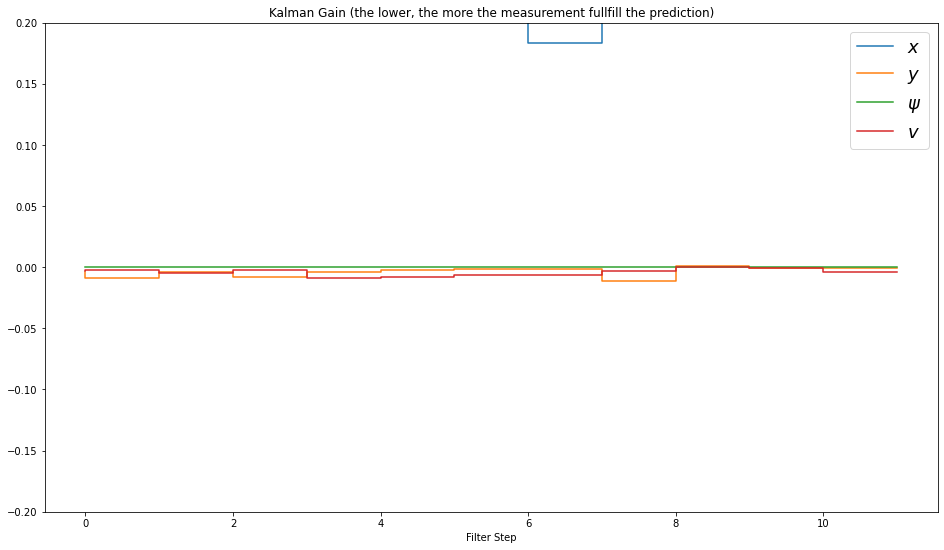

In [8]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kdx, label='$\psi$')
plt.step(range(m),Kdy, label='$v$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.2,0.2]);

### Uncertainties

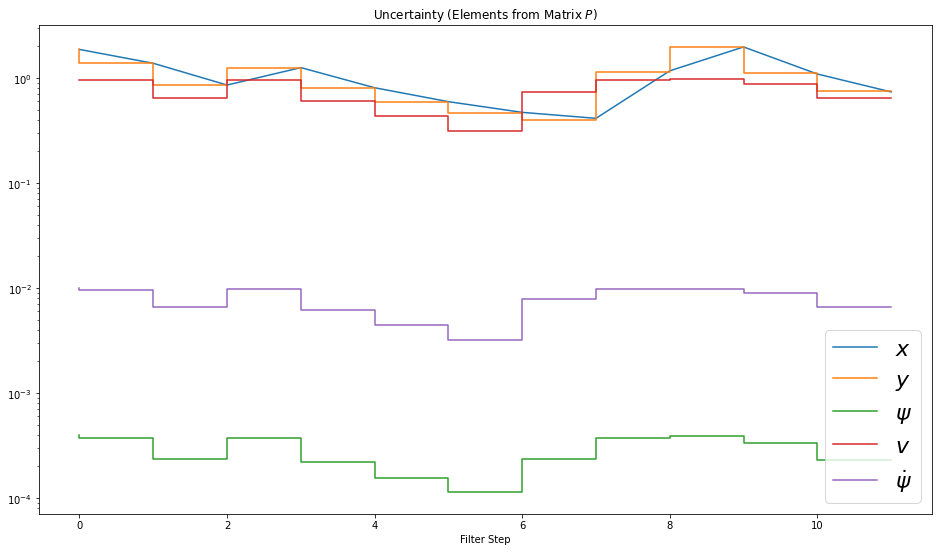

In [9]:

fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Position x/y

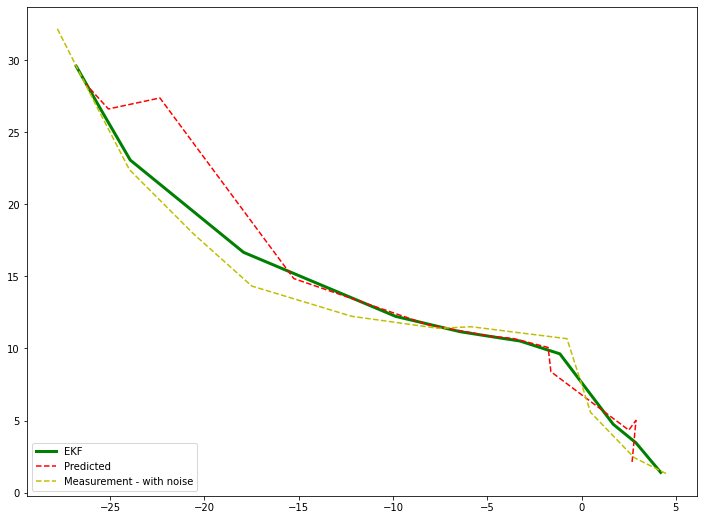

In [10]:
fig = plt.figure(figsize=(12,9))

x_measurement, y_measurement = measurements_mock[:, STATE_X_IDX], measurements_mock[:, STATE_Y_IDX]
x_noisy_measurement, y_noisy_measurement, x_predicted, y_predicted = np.array(
    [x_noisy_measurement, y_noisy_measurement, x_predicted, y_predicted],
    dtype='float64'
)

plt.plot(x0, x1, label='EKF', c='g', lw=3)
plt.plot(x_predicted, y_predicted, label='Predicted', c='r', lw=1.5, ls='--')

# plt.plot(x_measurement, y_measurement, label='Measurement - no noise', c='b', lw=1.5, ls=':')
plt.plot(x_noisy_measurement, y_noisy_measurement, label='Measurement - with noise', c='y', lw=1.5, ls='--')

plt.legend(loc="lower left")
plt.show()